# Setup the requirement libraries

In [1]:
!pip install gym
!pip install numpy

# Setup an environment

In [1]:
def setup_environment(env_name):
    import gym
    env = gym.make(env_name).env
    env.reset()  # reset environment to a new, random state
    env.render()
    print("Action Space {}".format(env.action_space))
    print("State Space {}".format(env.observation_space))
    return env

## Choose your environment from the available environments below

In [2]:
environment_names=["Taxi-v3","FrozenLake-v1","CliffWalking-v0"]
env=setup_environment(environment_names[0])
env.render()

C:\Users\Kirolos\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\envs\registration.py:423: UserWarning: WARN: Custom namespace `ALE` is being overridden by namespace `ALE`. If you are developing a plugin you shouldn't specify a namespace in `register` calls. The namespace is specified through the entry point package metadata.
  logger.warn(


Action Space Discrete(6)
State Space Discrete(500)


# Try to take random actions to achieve the goal

In [3]:
def random_action_to_end(env):
    epochs = 0
    penalties, reward = 0, 0
    frames = []  # for animation
    done = False
    while not done:
      # automatically selects one random action
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        if reward == -10:
            penalties += 1

        # Put each rendered frame into dict for animation
        frames.append({
            'frame': env.render(mode='ansi'),
            'state': state,
            'action': action,
            'reward': reward
            }
        )
        epochs += 1

    print("Timesteps taken: {}".format(epochs))
    print("Penalties incurred: {}".format(penalties))
    return frames

In [4]:
def print_frames(frames):
    from IPython.display import clear_output
    from time import sleep
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        #print(frame['frame'].getvalue())
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.1)

In [8]:
frames=random_action_to_end(env)

Timesteps taken: 67
Penalties incurred: 22


In [9]:
print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 67
State: 410
Action: 5
Reward: 20


# Train the agent using Q-learning algorithm

In [7]:
import random
from IPython.display import clear_output
import numpy as np
def train_the_agent(env,alpha,gamma,epsilon,training_steps,decay_steps,decay=False):
    q_table = np.zeros([env.observation_space.n, env.action_space.n])
    alpha_decay=1e-3
    gamma_decay=1e-3
    epsilon_decay=1e-3
    learning_epochs=[]
    learning_penalties=[]
    for i in range(1,training_steps ):
        state = env.reset()
        epochs, penalties, reward, = 0, 0, 0
        done = False
        if decay and not i % decay_steps :
            alpha-=alpha_decay
            gamma-=gamma_decay
            epsilon-=epsilon_decay
        while not done:
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample() # Explore action space
            else:
                action = np.argmax(q_table[state]) # Exploit learned values

            next_state, reward, done, info = env.step(action)

            old_value = q_table[state, action]
            next_max = np.max(q_table[next_state])

            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state, action] = new_value

            if reward == -10:
                penalties += 1

            state = next_state
            epochs += 1

        if i % 100 == 0:
            clear_output(wait=True)
            print(f"Episode: {i}")
        learning_epochs.append(epochs)
        learning_penalties.append(penalties)

    print("Training finished.\n")
    return q_table,learning_epochs,learning_penalties

In [13]:
q_table,learning_epochs,learning_penalties=train_the_agent(env,alpha=0.1,gamma=0.6,epsilon=0.1,decay_steps=10000,training_steps=100001,decay=True)

Episode: 100000
Training finished.



# Evaluation
Evaluate agent's performance after Q-learning

In [17]:
def evaluate(q_table,episodes):
    total_epochs, total_penalties = 0, 0
    for _ in range(episodes):
        # Choose random initial state
        state = env.reset()
        epochs, penalties, reward = 0, 0, 0
        done = False
        frames=[]
        while not done:
            action = np.argmax(q_table[state])
            # print(action)
            state, reward, done, info = env.step(action)
            # Put each rendered frame into dict for animation
            frames.append({
            'frame': env.render(mode='ansi'),
            'state': state,
            'action': action,
            'reward': reward
            }
            )

            if reward == -10:
                penalties += 1

            epochs += 1

        total_penalties += penalties
        total_epochs += epochs
    print_frames(frames)
    print(f"Results after {episodes} episodes:")
    print(f"Average timesteps per episode: {total_epochs / episodes}")
    print(f"Average penalties per episode: {total_penalties / episodes}")
    return total_epochs,total_penalties

In [18]:
total_epochs,total_penalties=evaluate(q_table=q_table,episodes=100)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 13
State: 0
Action: 5
Reward: 20
Results after 100 episodes:
Average timesteps per episode: 12.69
Average penalties per episode: 0.0


# Grid search to get the best hyperparameter

In [20]:
import pandas as pd
alpha=[0.1,0.3,0.5,0.9]
gamma=[0.3,0.6,0.8,0.9]
epsilon=[0.7,0.6,0.8,0.9]
best_alpha,best_gamma,best_epsilon=0,0,0
mini_penalties=999999999999999999
mini_epochs=9999999999999999
parameters={
    "Alpha":[],
    "Gamma":[],
    "Epsilon":[],
    "Evaluation Total Penalties":[],
    "Evaluation Total Epochs":[],
}
for ep in epsilon :
    for al in alpha :
        for gm in gamma :
            returned_q_table=train_the_agent(env=env,alpha=al,gamma=gm,epsilon=ep,decay_steps=10000,training_steps=100000,decay=False)
            total_epochs,total_penalties=evaluate(returned_q_table,100)
            parameters['Alpha'].append(al)
            parameters['Gamma'].append(gm)
            parameters['Epsilon'].append(ep)
            parameters['Evaluation Total Penalties'].append(total_penalties)
            parameters['Evaluation Total Epochs'].append(total_epochs)
            if total_penalties<=mini_penalties:
                mini_penalties=total_penalties
                best_alpha=al
                best_gamma=gm
                best_epsilon=ep
            if  total_epochs<=mini_epochs:
                total_epochs=mini_epochs
                best_alpha=al
                best_gamma=gm
                best_epsilon=ep

parameters=pd.DataFrame(parameters)
print(parameters)
print(best_alpha,best_gamma,best_epsilon)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 11
State: 85
Action: 5
Reward: 20
Results after 100 episodes:
Average timesteps per episode: 12.98
Average penalties per episode: 0.0
    Alpha  Gamma  Epsilon  Evaluation Total Penalties  Evaluation Total Epochs
0     0.1    0.3      0.7                           0                     1303
1     0.1    0.6      0.7                           0                     1300
2     0.1    0.8      0.7                           0                     1328
3     0.1    0.9      0.7                           0                     1316
4     0.3    0.3      0.7                           0                     1245
..    ...    ...      ...                         ...                      ...
59    0.5    0.9      0.9                           0                     1354
60    0.9    0.3      0.9                           0                     1303
61    0.9    0.6      0.9                       

In [21]:
parameters

,Alpha,Gamma,Epsilon,Evaluation Total Penalties,Evaluation Total Epochs
0,0.1,0.3,0.7,0,1303
1,0.1,0.6,0.7,0,1300
2,0.1,0.8,0.7,0,1328
3,0.1,0.9,0.7,0,1316
4,0.3,0.3,0.7,0,1245
...,...,...,...,...,...
59,0.5,0.9,0.9,0,1354
60,0.9,0.3,0.9,0,1303
61,0.9,0.6,0.9,0,1280
62,0.9,0.8,0.9,0,1347


# Train with the best hyper parameters

In [8]:
best_q_table,learning_epochs,learning_penalties=train_the_agent(env,0.9,0.9,0.9,training_steps=100000,decay_steps=10000,decay=True)

Episode: 99900
Training finished.



### Plot the Penalties and number of epochs in each iteration

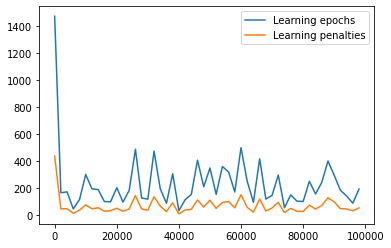

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
bins=list(range(0,100000,2000))
np_learning_epochs=np.array(learning_epochs)
np_learning_penalties=np.array(learning_penalties)
sns.lineplot(x=bins, y=np_learning_epochs[bins],label='Learning epochs')
sns.lineplot(x=bins, y=np_learning_penalties[bins],label='Learning penalties')
plt.show()

# Visualization of trained model over number of episodes

In [24]:
total_epochs, total_penalties = 0, 0
episodes = 500
for episode in range(episodes):
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0
    done = False
    frames=[]
    while not done:
        action = np.argmax(best_q_table[state])
        state, reward, done, info = env.step(action)
        # Put each rendered frame into dict for animation
        frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        }
        )
        if reward == -10:
            penalties += 1

        epochs += 1
    total_penalties += penalties
    total_epochs += epochs
    clear_output(wait=False)
    print_frames(frames=frames)
    print(f"Episode {episode}")

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 14
State: 475
Action: 5
Reward: 20
Episode 499
Results after 500 episodes:
Average timesteps per episode: 12.918
Average penalties per episode: 0.0
